<a href="https://colab.research.google.com/github/Anthony5234534/STAT3011-Project-II/blob/main/Edited_Customer_Life_Time_Value_Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Lifetime Values
Using the **Beta-Geometric/Negative Binomial Distribution** a Buy-til-You-Die Model for predicting Customer Lifetime Value

# Let's go through the offiial lifetimes tutorial
https://lifetimes.readthedocs.io/en/latest/Quickstart.html

In [ ]:
# Install lifetimes
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.6 MB/s eta 0:00:00


In [ ]:
from lifetimes.datasets import load_cdnow_summary

data = load_cdnow_summary(index_col=[0])

print(data.head())

    frequency  recency      T
ID                           
1           2    30.43  38.86
2           1     1.71  38.86
3           0     0.00  38.86
4           0     0.00  38.86
5           0     0.00  38.86


- **frequency** represents the number of repeat purchases the customer has made. This means that it’s one less than the total number of purchases. This is actually slightly wrong. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.
- **T** represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.
- **recency** represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase, the recency is 0.)
- **monetary_value** represents the average value of a given customer’s purchases. This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

# Basic Frequency/Recency analysis using the BG/NBD model

We’ll use the BG/NBD model first. There are other models which we will explore in these docs, but this is the simplest to start with.

In [ ]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 2357 subjects, a: 0.79, alpha: 4.41, b: 2.43, r: 0.24>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.242593,0.012557,0.217981,0.267205
alpha,4.413532,0.378221,3.672218,5.154846
a,0.792886,0.185719,0.428877,1.156895
b,2.425752,0.705345,1.043276,3.808229


After fitting, we have lots of nice methods and properties attached to the fitter object, like param_ and summary.

For small samples sizes, the parameters can get implausibly large, so by adding an l2 penalty the likelihood, we can control how large these parameters can be. This is implemented as setting as positive penalizer_coef in the initialization of the model. In typical applications, penalizers on the order of 0.001 to 0.1 are effective.

# Visualizing our Frequency/Recency Matrix
Consider: a customer bought from you every day for three weeks straight, and we haven’t heard from them in months. What are the chances they are still “alive”? Pretty small. On the other hand, a customer who historically buys from you once a quarter, and bought last quarter, is likely still alive. We can visualize this relationship using the Frequency/Recency matrix, which computes the expected number of transactions a artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made).

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

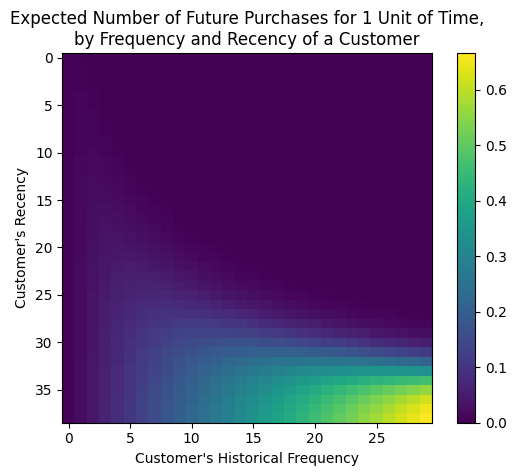

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 25 times from you, and their latest purchase was when they were 35 weeks old (given the individual is 35 weeks old), then they are your best customer (bottom-right). Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.

There’s also that beautiful “tail” around (5,25). That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases.

Another interesting matrix to look at is the probability of still being alive:

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

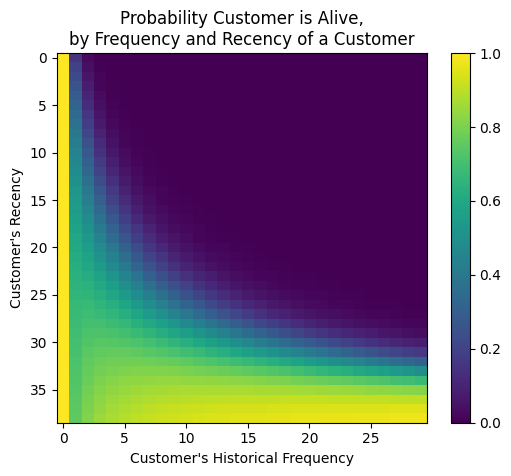

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

# Ranking customers from best to worst
Let’s return to our customers and rank them from “highest expected purchases in the next period” to lowest. Models expose a method that will predict a customer’s expected purchases in the next period using their history.

In [ ]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,predicted_purchases
ID,,,,
509,18,35.14,35.86,1.252854
841,19,34.00,34.14,1.398731
1981,17,28.43,28.86,1.429807
157,29,37.71,38.00,1.953790
1516,26,30.86,31.00,2.089581


Great, we can see that the customer who has made 26 purchases, and bought very recently from us, is probably going to buy again in the next period.

# Assessing model fit
Ok, we can predict and we can visualize our customers’ behaviour, but is our model correct? There are a few ways to assess the model’s correctness. The first is to compare your data versus artificial data simulated with your fitted model’s parameters.

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

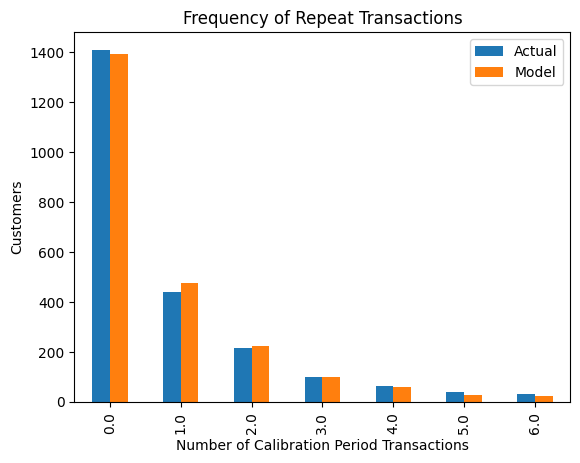

In [ ]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

# Question: How to compare?

# Using it on pur own transactional dataset

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Uncomment this line if using this notebook locally
#df = pd.read_excel('./data/retail/Online Retail.xlsx', sheet_name='Online Retail')

file_name = "https://raw.githubusercontent.com/rajeevratan84/datascienceforbusiness/master/OnlineRetail.xlsx"
df = pd.read_excel(file_name, sheet_name='Online Retail')

df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Remove blank customer IDs
df = df.loc[df['Quantity'] > 0]
df = df[pd.notnull(df['CustomerID'])]

In [ ]:
# Extrat columns and rename
transaction_data = df[['InvoiceDate','CustomerID']]
transaction_data.columns = ['date','id']
transaction_data.head()

,date,id
0,2010-12-01 08:26:00,17850.0
1,2010-12-01 08:26:00,17850.0
2,2010-12-01 08:26:00,17850.0
3,2010-12-01 08:26:00,17850.0
4,2010-12-01 08:26:00,17850.0


In [ ]:
print(transaction_data['date'].max())
print(transaction_data['date'].min())

2011-12-09 12:50:00
2010-12-01 08:26:00


In [ ]:
from lifetimes.utils import summary_data_from_transaction_data
summary = summary_data_from_transaction_data(transaction_data, 'id', 'date', observation_period_end='2011-12-09')
summary

,frequency,recency,T
id,,,
12346.0,0.0,0.0,325.0
12347.0,6.0,365.0,367.0
12348.0,3.0,283.0,358.0
12349.0,0.0,0.0,18.0
12350.0,0.0,0.0,310.0
...,...,...,...
18280.0,0.0,0.0,277.0
18281.0,0.0,0.0,180.0
18282.0,1.0,119.0,126.0


# Basic Frequency/Recency analysis using the BG/NBD model

In [ ]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(bgf)
bgf.summary

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826433,0.026780,0.773944,0.878922
alpha,68.890678,2.611055,63.773011,74.008345
a,0.003443,0.010347,-0.016837,0.023722
b,6.749363,22.412933,-37.179985,50.678711


# Visualizing our Frequency/Recency Matrix

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

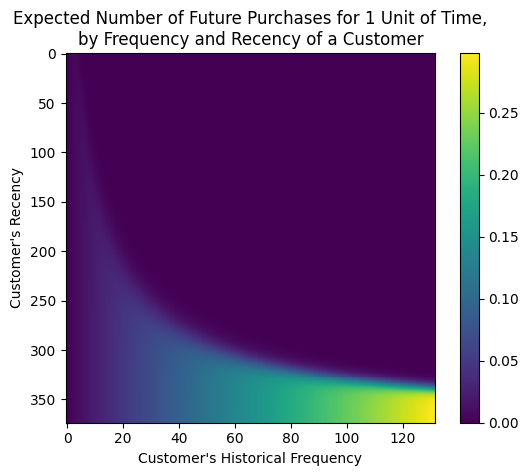

In [ ]:
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

# Probability of still being alive:

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

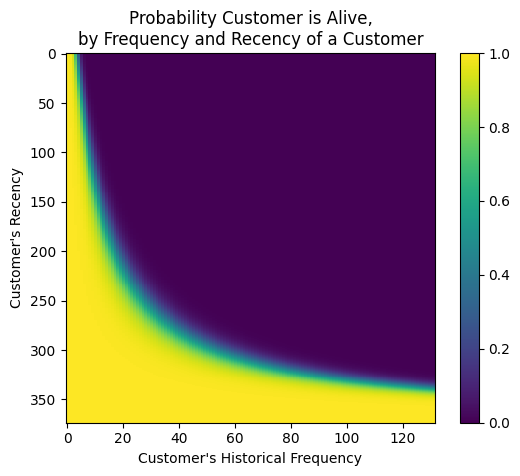

In [ ]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

# Ranking customers from best to worst

In [ ]:
t = 90
summary['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary.sort_values(by='predicted_purchases')

,frequency,recency,T,predicted_purchases
id,,,,
15107.0,5.0,61.0,372.0,0.000984
16725.0,5.0,69.0,371.0,0.001830
12845.0,3.0,23.0,290.0,0.002321
13093.0,6.0,98.0,373.0,0.003775
17850.0,1.0,1.0,373.0,0.004361
...,...,...,...,...
14606.0,88.0,372.0,373.0,19.116138
15311.0,89.0,373.0,373.0,19.379109
17841.0,111.0,372.0,373.0,24.131576


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

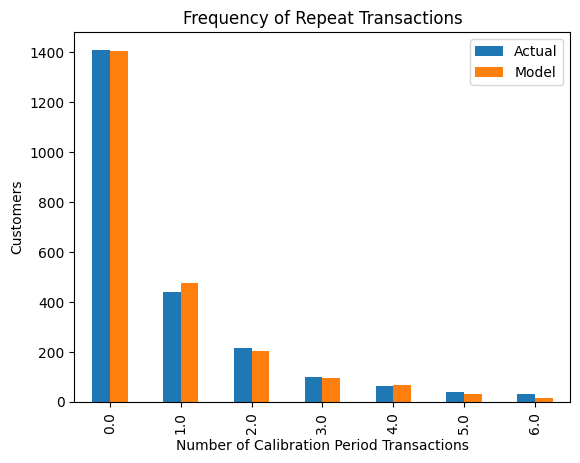

In [ ]:
from lifetimes.plotting import plot_period_transactions

plot_period_transactions(bgf)

# Estimating customer lifetime value using the Gamma-Gamma model

For this whole time we didn’t take into account the economic value of each transaction and we focused mainly on transactions’ occurrences. To estimate this we can use the Gamma-Gamma submodel. But first we need to create summary data from transactional data also containing economic values for each transaction (i.e. profits or revenues

**But firstly looking at the lifetime tutorials, let's see how our input dataset is expected to look.**

In [ ]:
from lifetimes.datasets import load_cdnow_summary_data_with_monetary_value

summary_with_money_value = load_cdnow_summary_data_with_monetary_value()
summary_with_money_value.head()

,frequency,recency,T,monetary_value
customer_id,,,,
1,2,30.43,38.86,22.35
2,1,1.71,38.86,11.77
3,0,0.00,38.86,0.00
4,0,0.00,38.86,0.00
5,0,0.00,38.86,0.00


# Transforming out dataset

In [ ]:
transaction_data_monetary = df[['InvoiceDate','CustomerID', 'Quantity', 'UnitPrice']]
transaction_data_monetary['Spent'] = transaction_data_monetary['Quantity'] * transaction_data_monetary['UnitPrice']
grouped = transaction_data_monetary.groupby('CustomerID')['Spent'].mean().reset_index()
grouped.columns = ['id','monetary_value']
grouped.head()

,id,monetary_value
0,12346.0,77183.600000
1,12347.0,23.681319
2,12348.0,57.975484
3,12349.0,24.076027
4,12350.0,19.670588


In [ ]:
# Creating our summary_with_money
summary_with_monetary = pd.merge(summary, grouped, on='id')
summary_with_monetary.set_index('id').head()

,frequency,recency,T,predicted_purchases,monetary_value
id,,,,,
12346.0,0.0,0.0,325.0,0.063724,77183.600000
12347.0,6.0,365.0,367.0,1.269993,23.681319
12348.0,3.0,283.0,358.0,0.548074,57.975484
12349.0,0.0,0.0,18.0,0.678946,24.076027
12350.0,0.0,0.0,310.0,0.066646,19.670588


In [ ]:
# Our returning customers summary
returning_customers_summary = summary_with_monetary[summary_with_monetary['frequency']>0]

print(returning_customers_summary.head())

         id  frequency  recency      T  predicted_purchases  monetary_value
1   12347.0        6.0    365.0  367.0             1.269993       23.681319
2   12348.0        3.0    283.0  358.0             0.548074       57.975484
5   12352.0        6.0    260.0  296.0             1.388360       29.482824
9   12356.0        2.0    303.0  325.0             0.453068       47.651356
11  12358.0        1.0    149.0  150.0             0.489253       61.476842


# The Gamma-Gamma model and the independence assumption
The model we are going to use to estimate the CLV for our userbase is called the Gamma-Gamma submodel, which relies upon an important assumption. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [ ]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.005296
frequency,-0.005296,1.000000


At this point we can train our Gamma-Gamma submodel and predict the conditional, expected average lifetime value of our customers.

In [ ]:
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 6.91, q: 2.04, v: 4.38>



We can now estimate the average transaction value:

In [ ]:
predicted_avg_profit = ggf.conditional_expected_average_profit(
        returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])

In [ ]:
# Added
returning_customers_summary['predicted_avg_profit'] = predicted_avg_profit
returning_customers_summary


,id,frequency,recency,T,predicted_purchases,monetary_value,predicted_avg_profit,CLV
1,12347.0,6.0,365.0,367.0,1.269993,23.681319,23.815325,53.730661
2,12348.0,3.0,283.0,358.0,0.548074,57.975484,56.602728,5.585308
5,12352.0,6.0,260.0,296.0,1.388360,29.482824,29.475212,11.514988
9,12356.0,2.0,303.0,325.0,0.453068,47.651356,46.361006,65.601994
11,12358.0,1.0,149.0,150.0,0.489253,61.476842,57.259912,103.082951
...,...,...,...,...,...,...,...,...
4328,18272.0,5.0,244.0,246.0,1.514150,18.545663,18.855394,NaN
4329,18273.0,2.0,255.0,257.0,0.578287,68.000000,65.288851,NaN
4336,18282.0,1.0,119.0,126.0,0.560791,14.837500,16.708472,NaN
4337,18283.0,13.0,334.0,337.0,3.022255,2.771005,3.072400,NaN


[連結文字](https://)While for computing the total CLV using the DCF method (https://en.wikipedia.org/wiki/Discounted_cash_flow) adjusting for cost of capital:

# Our Customer Life Time Values!

In [ ]:
# The orginal extra file cannot show the result well

bgf.fit(summary_with_money_value['frequency'], summary_with_money_value['recency'], summary_with_money_value['T'])

CLV = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    summary_with_money_value['frequency'],
    summary_with_money_value['recency'],
    summary_with_money_value['T'],
    summary_with_money_value['monetary_value'],
    time=3, # months
    # discount_rate=0.01 # monthly discount rate ~ 12.7% annually
)



NameError: name 'bgf' is not defined

In [ ]:
# Added:  Predicting the CLV.
returning_customers_summary['CLV'] = ggf.customer_lifetime_value(
    bgf,
    returning_customers_summary['frequency'],
    returning_customers_summary['recency'],
    returning_customers_summary['T'],
    returning_customers_summary['monetary_value'],
    time = 3,# In months
    )
returning_customers_summary

,id,frequency,recency,T,predicted_purchases,monetary_value,predicted_avg_profit,CLV
1,12347.0,6.0,365.0,367.0,1.269993,23.681319,23.815325,29.659343
2,12348.0,3.0,283.0,358.0,0.548074,57.975484,56.602728,30.420517
5,12352.0,6.0,260.0,296.0,1.388360,29.482824,29.475212,40.131976
9,12356.0,2.0,303.0,325.0,0.453068,47.651356,46.361006,20.597102
11,12358.0,1.0,149.0,150.0,0.489253,61.476842,57.259912,27.476024
...,...,...,...,...,...,...,...,...
4328,18272.0,5.0,244.0,246.0,1.514150,18.545663,18.855394,28.000024
4329,18273.0,2.0,255.0,257.0,0.578287,68.000000,65.288851,37.025340
4336,18282.0,1.0,119.0,126.0,0.560791,14.837500,16.708472,9.190473
4337,18283.0,13.0,334.0,337.0,3.022255,2.771005,3.072400,9.106229
